In [16]:
import xarray as xr
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from pyschism.mesh import Hgrid, Vgrid


# The helper functions and class remain mostly the same
def inverse_distance_weights(distances: np.ndarray, power: float = 1.0) -> np.ndarray:
    safe_distances = np.maximum(distances, 1e-6)
    weights = 1.0 / np.power(safe_distances, power)
    return weights / weights.sum(axis=1, keepdims=True)

class NearestSpatialLocator:
    def __init__(self, x_coords: np.ndarray, y_coords: np.ndarray) -> None:
        self.tree = KDTree(np.column_stack((x_coords, y_coords)))

    def query(self, lon: np.ndarray, lat: np.ndarray, k: int = 3) -> tuple[np.ndarray, np.ndarray]:
        points = np.column_stack((lon, lat))
        return self.tree.query(points, k=k)

def create_transect_file(start_coords, end_coords, step_degrees, filename="transect.bp"):
    lon1, lat1 = start_coords
    lon2, lat2 = end_coords
    total_dist = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2)
    num_points = int(np.ceil(total_dist / step_degrees)) + 1
    lons = np.linspace(lon1, lon2, num_points)
    lats = np.linspace(lat1, lat2, num_points)
    with open(filename, 'w') as f:
        f.write(f"{num_points}\n")
        for i in range(num_points):
            f.write(f"{i+1} {lons[i]:.6f} {lats[i]:.6f} 1\n")
    print(f"✅ Successfully created '{filename}' with {num_points} points.")

# --- CORRECTED HELPER FUNCTION ---

def interpolate_nodal_data(data_1d: np.ndarray, neighbor_indices: np.ndarray, idw_weights: np.ndarray) -> np.ndarray:
    """Interpolates 1D nodal data (e.g., depth, lat) onto transect points."""
    flat_indices = neighbor_indices.flatten()
    selected_data_1d = data_1d[flat_indices]
    selected_data = np.reshape(selected_data_1d, neighbor_indices.shape)
    
    weighted_data = selected_data * idw_weights
    
    # *** THE FIX IS HERE ***
    # If k=1, arrays are 1D and no sum is needed. If k>1, arrays are 2D, so sum along axis 1.
    if weighted_data.ndim == 1:
        return weighted_data  # k=1 case
    else:
        return np.sum(weighted_data, axis=1)  # k>1 case

def build_vertical_profile(data_source: xr.DataArray or np.ndarray,
                           vertical_layers: np.ndarray,
                           neighbor_indices: np.ndarray,
                           idw_weights: np.ndarray,
                           timestep: int = None) -> np.ndarray:
    """Builds a 2D vertical profile by interpolating data layer by layer."""
    profile_layers = []
    for z in vertical_layers:
        if timestep is not None and isinstance(data_source, xr.DataArray):
            layer_data = data_source[timestep, :, z].values
        else:
            layer_data = data_source[:, z]

        interpolated_layer = interpolate_nodal_data(layer_data, neighbor_indices, idw_weights)
        profile_layers.append(interpolated_layer)
    
    return np.array(profile_layers)

In [17]:
CONFIG = {
    "base_path": r"C:\Users\Felicio.Cassalho\Work\Literature\AK_Paper_01\Figures\extra_materials\vertical_prof/",
    "transect_start": (185.00, 51.50),
    "transect_end": (185.00, 53.50),
    "transect_step_deg": 0.02,
    "transect_filename": "transect.bp",
    "k_neighbors": 1,
    "variable_to_plot": "temperature",  # Change to "salinity", etc.
    "timestep_to_plot": 0,
    "plot_vmin": 3,
    "plot_vmax": 6,
    "plot_depth_limit": 600
}

In [18]:
# --- 2. SETUP ---
create_transect_file(CONFIG["transect_start"], CONFIG["transect_end"], CONFIG["transect_step_deg"], CONFIG["transect_filename"])
bp = np.loadtxt(CONFIG["transect_filename"], delimiter=' ', skiprows=1)
bpx, bpy = bp[:, 1], bp[:, 2]

✅ Successfully created 'transect.bp' with 101 points.


In [7]:
# --- 3. LOAD MODEL GRID & DATA ---
hgrid_path = f'{CONFIG["base_path"]}/hgrid.gr3'
vgrid_path = f'{CONFIG["base_path"]}/vgrid.in'
# NOTE: Assumes model output file is named like 'temperature_0.nc'
model_output_path = f'{CONFIG["base_path"]}/outputs/{CONFIG["variable_to_plot"]}_{CONFIG["timestep_to_plot"]}.nc'

hgrid = Hgrid.open(hgrid_path, crs=4326)
vgrid = Vgrid.open(vgrid_path)
model_output = xr.open_dataset(model_output_path)

# Extract the main data variable dynamically
data_variable = model_output[CONFIG["variable_to_plot"]]

In [19]:
# --- 4. SPATIAL INTERPOLATION SETUP ---
mesh_tree = NearestSpatialLocator(hgrid.x, hgrid.y)
nodes_weight, nodes_query = mesh_tree.query(bpx, bpy, k=CONFIG["k_neighbors"])
idw = inverse_distance_weights(nodes_weight) if CONFIG["k_neighbors"] > 1 else np.ones_like(nodes_weight)

In [30]:
# --- 5. INTERPOLATE DATA TO TRANSECT ---
# Use the new helper function for 1D nodal data
final_depth_values = interpolate_nodal_data(hgrid.values, nodes_query, idw)
final_lat_values = interpolate_nodal_data(hgrid.y, nodes_query, idw)

vertical_layers_indices = np.flip(np.arange(data_variable.shape[-1]))
profile = build_vertical_profile(data_variable, vertical_layers_indices, nodes_query, idw, timestep=CONFIG["timestep_to_plot"])
profile_sig = build_vertical_profile(vgrid.sigma, vertical_layers_indices, nodes_query, idw)
scaled_profile = profile_sig * final_depth_values

In [32]:
# --- 6. DATA CLEANING FOR PLOTTING ---
# (This section remains the same)
invalid_coords_mask = np.isnan(scaled_profile)
scaled_profile_cleaned = scaled_profile.copy()
profile_cleaned = profile.copy()
profile_cleaned[invalid_coords_mask] = np.nan
scaled_profile_cleaned[invalid_coords_mask] = 0

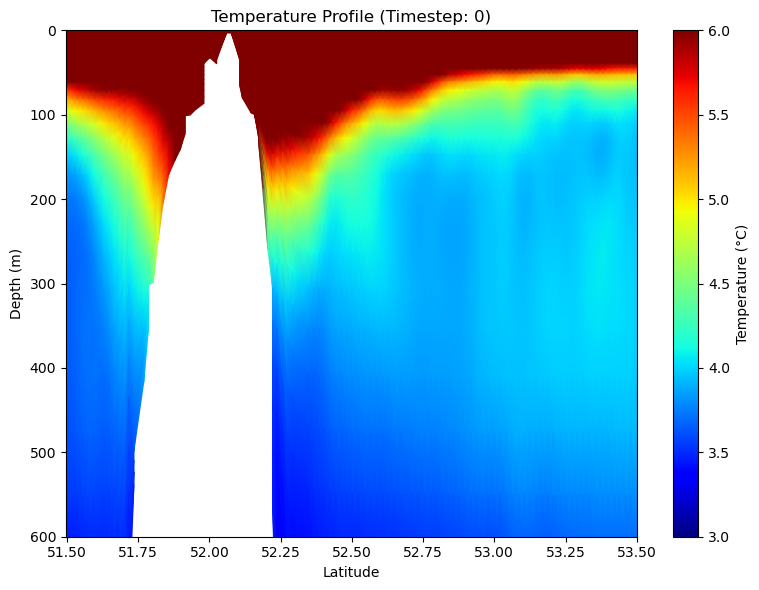

In [35]:
# --- 7. PLOTTING ---
plt.figure(figsize=(8, 6))
plt.pcolormesh(final_lat_values, scaled_profile_cleaned, profile_cleaned,
               shading='gouraud', cmap='jet', vmin=CONFIG["plot_vmin"], vmax=CONFIG["plot_vmax"])
plt.colorbar(label=f'{CONFIG["variable_to_plot"].capitalize()} (°C)')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title(f'{CONFIG["variable_to_plot"].capitalize()} Profile (Timestep: {CONFIG["timestep_to_plot"]})')
plt.gca().invert_yaxis()
plt.ylim(CONFIG["plot_depth_limit"], 0)
plt.tight_layout()
plt.show()

In [1]:
import xarray as xr

import numpy as np
from scipy.spatial import KDTree
import math

from pyschism.mesh import Hgrid, Vgrid

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

import seawater as sw

C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def inverse_distance_weights(distances: np.ndarray,
                             power: float = 1.0) -> np.ndarray:
    """
    Compute inverse distance weights (IDW) with configurable exponent.

    Parameters
    ----------
    distances : np.ndarray
        Distance array to nearest neighbors, shape (N, k)
    power : float, optional
        Power exponent for distance weighting (default is 1.0).
        Use 1.0 for linear, 2.0 for quadratic, etc.

    Returns
    -------
    np.ndarray
        Normalized inverse distance weights of shape (N, k)

    Notes
    -----
    A small epsilon (1e-6) is used to avoid division by zero.
    """
    safe_distances = np.maximum(distances, 1e-6) #to avoid division by zero
    weights = 1.0 / np.power(safe_distances, power)
    return weights / weights.sum(axis=1, keepdims=True)

class NearestSpatialLocator:
    """KDTree-based spatial query engine

    Handles nearest-neighbor lookups between satellite points and
    model grid nodes using a fast cKDTree.

    Methods
    -------
    query(lon, lat, k=3) -> Tuple[np.ndarray, np.ndarray]
        Query for the `k` nearest model nodes to each satellite point.

    Notes
    -----
    Coordinates are assumed to be in the same projected or geodetic
    system (e.g., lon/lat or UTM).
    """

    def __init__(self,
                 x_coords: np.ndarray,
                 y_coords: np.ndarray) -> None:
        """
        Parameters
        ----------
        x_coords : np.ndarray
            X-coordinates (e.g., longitude) of model mesh nodes
        y_coords : np.ndarray
            Y-coordinates (e.g., latitude) of model mesh nodes
        """
        self.tree = KDTree(np.column_stack((x_coords, y_coords)))

    def query(self,
              lon: np.ndarray,
              lat: np.ndarray,
              k: int = 3) -> tuple[np.ndarray, np.ndarray]:
        """
        Parameters
        ----------
        lon : np.ndarray
            Longitudes of satellite observations
        lat : np.ndarray
            Latitudes of satellite observations
        k : int, optional
            Number of nearest model neighbors to return (default is 3)

        Returns
        -------
        tuple of np.ndarray
            Distances and indices of nearest model nodes, both of shape (N, k)
        """
        points = np.column_stack((lon, lat))
        distances, indices = self.tree.query(points, k=k)
        return distances, indices

In [3]:
def create_transect_file(start_coords, end_coords, step_degrees, filename="transect.bp"):
    """
    Generates a SCHISM-style transect file (.bp) between two points.

    Args:
        start_coords (tuple): A tuple of (start_longitude, start_latitude).
        end_coords (tuple): A tuple of (end_longitude, end_latitude).
        step_degrees (float): The desired spacing between points in degrees.
        filename (str): The name of the output file.
    """
    lon1, lat1 = start_coords
    lon2, lat2 = end_coords

    # Calculate the total distance in the coordinate space to determine the number of points
    total_dist = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2)
    
    # Determine the number of points needed. We use ceiling to ensure the final point is included.
    # The +1 accounts for the starting point itself.
    num_points = int(np.ceil(total_dist / step_degrees)) + 1

    # Generate evenly spaced longitude and latitude points
    # np.linspace is perfect for creating points in a straight line between two ends.
    lons = np.linspace(lon1, lon2, num_points)
    lats = np.linspace(lat1, lat2, num_points)

    # Write the data to the file
    with open(filename, 'w') as f:
        # First line is the total number of points
        f.write("transect.bp\n")
        f.write(f"{num_points}\n")

        # Subsequent lines are the formatted points
        for i in range(num_points):
            index = i + 1
            # Format to 6 decimal places for good precision
            line = f"{index} {lons[i]:.6f} {lats[i]:.6f} 1\n"
            f.write(line)
            
    print(f"✅ Successfully created '{filename}' with {num_points} points.")

✅ Successfully created 'transect.bp' with 101 points.


In [ ]:
# 1. Define your start and end coordinates
start_point = (185.00, 51.50)  # (longitude, latitude)
end_point = (185.00, 53.50)    # (longitude, latitude)

# 2. Define your desired spacing
step = 0.02

# 3. Call the function to create the file
create_transect_file(start_point, end_point, step, filename="transect.bp")

In [4]:
path = r"C:\Users\Felicio.Cassalho\Work\Literature\AK_Paper_01\Figures\extra_materials\vertical_prof/"

hgrid = Hgrid.open(f"{path}/hgrid.gr3", crs=4326)
model_depths = hgrid.values
latitude = hgrid.y
temp = xr.open_dataset(f"{path}/outputs/temperature_0.nc")
#salt = xr.open_dataset(f"{path}/outputs/salinity_0.nc")
vgrid = Vgrid.open(f"{path}/vgrid.in")
vsig = vgrid.sigma

In [7]:
bp = np.loadtxt(f"./transect.bp", delimiter=' ', skiprows=2)
bpx, bpy = bp[:,1], bp[:,2]

In [8]:
mesh_tree = NearestSpatialLocator(hgrid.x,hgrid.y)
nodes_weight,nodes_query = mesh_tree.query(bpx, bpy, k=1)

In [10]:
try:
    idw = inverse_distance_weights(nodes_weight)
except:
    idw = [1 for i in nodes_weight]

In [12]:
flat_indices_depth = nodes_query.flatten()
selected_depths_1d = model_depths[flat_indices_depth]
selected_depths = np.reshape(selected_depths_1d, nodes_query.shape)
try:
    final_depth_values = np.sum(selected_depths * idw, axis=1)
except:
    final_depth_values = selected_depths 

In [13]:
profile = []
for z in np.flip(temp.nSCHISM_vgrid_layers):
    selected_temps_1d = temp.temperature[0][:,z].values[flat_indices_depth]
    selected_temps = np.reshape(selected_temps_1d, nodes_query.shape)
    try:
        final_temps_values = np.sum(selected_temps * idw, axis=1)
    except:
        final_temps_values = selected_temps
    profile.append(final_temps_values)

profile = np.array(profile)

In [17]:
for row in vsig:
    # 1. Find the indices of all -1 values in the current row
    indices = np.where(row == -1.)[0]
    
    # 2. If there is more than one occurrence, select all but the last index
    if len(indices) > 1:
        indices_to_replace = indices[:-1]
        
        # 3. Use these indices to replace the values in the current row
        row[indices_to_replace] = np.nan

In [18]:
profile_sig = []
for z in np.flip(temp.nSCHISM_vgrid_layers):
    selected_sig_1d = vsig[:,z][flat_indices_depth]
    selected_sig = np.reshape(selected_sig_1d, nodes_query.shape)
    try:
        final_sig_values = np.sum(selected_sig * idw, axis=1)
    except:
        final_sig_values = selected_sig
    profile_sig.append(final_sig_values)

profile_sig = np.array(profile_sig)
scaled_profile = profile_sig * final_depth_values

In [22]:
flat_indices_depth = nodes_query.flatten()
selected_lat_1d = latitude[flat_indices_depth]
selected_lat = np.reshape(selected_lat_1d, nodes_query.shape)
try:
    final_lat_values = np.sum(selected_lat * idw, axis=1)
except:
    final_lat_values = selected_lat

In [23]:
invalid_coords_mask = np.isnan(scaled_profile)
scaled_profile_cleaned = scaled_profile.copy()
profile_cleaned = profile.copy()
profile_cleaned[invalid_coords_mask] = np.nan
scaled_profile_cleaned[invalid_coords_mask] = 0

In [24]:
# levels = np.arange(3, 6.1, 0.5)
# cmap = plt.get_cmap('turbo') # Get the colormap
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

In [28]:
#sw.dens(profile_cleaned, profile_cleaned) - 1000

array([[7.170227  , 7.085388  , 6.9960938 , ..., 7.8397827 , 7.836548  ,
        7.8322144 ],
       [7.166504  , 7.081299  , 6.9926147 , ..., 7.8414917 , 7.838745  ,
        7.8344727 ],
       [7.1549683 , 7.0683594 , 6.982727  , ..., 7.842346  , 7.840027  ,
        7.8358765 ],
       ...,
       [0.90509033, 0.91955566, 0.9260254 , ..., 1.2367554 , 1.237793  ,
        1.2401123 ],
       [0.8466797 , 0.8597412 , 0.87854004, ..., 1.2044067 , 1.2051392 ,
        1.2068481 ],
       [0.81726074, 0.82366943, 0.85150146, ..., 1.1887207 , 1.1890869 ,
        1.1901245 ]], dtype=float32)

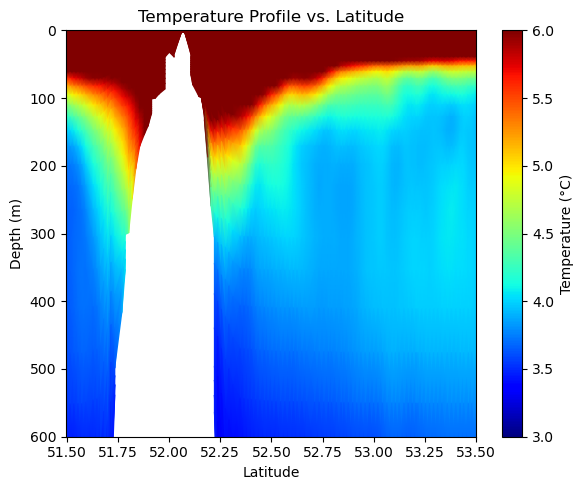

In [26]:
plt.figure(figsize=(6, 5))

# Use the CLEANED arrays for plotting
plt.pcolormesh(final_lat_values, scaled_profile_cleaned, profile_cleaned,
               shading='gouraud', cmap='jet', vmin=3, vmax=6)

# Add labels, a color bar, and a title
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile vs. Latitude')

# Invert the y-axis so depth increases downwards
plt.gca().invert_yaxis()

# --- 4. Control the Y-axis Zoom (Depth) ---
# Set the y-axis limits to show from 600m depth up to the surface (0m).
# Because we inverted the axis, the larger number comes first.
plt.ylim(600, 0)

# Ensure everything fits nicely
plt.tight_layout()

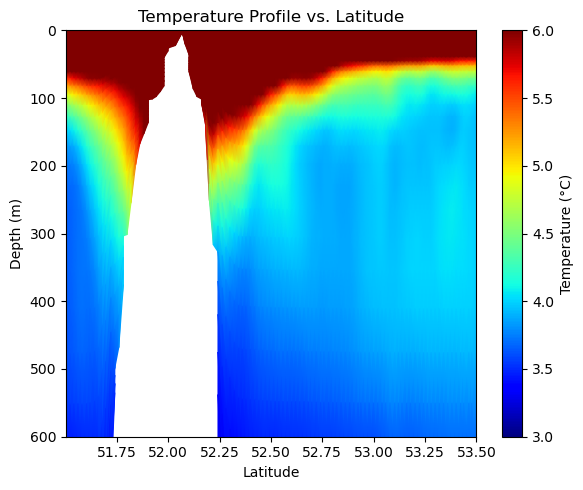

In [27]:
plt.figure(figsize=(6, 5))

# Use the CLEANED arrays for plotting
plt.pcolormesh(final_lat_values, scaled_profile_cleaned, profile_cleaned,
               shading='gouraud', cmap='jet', vmin=3, vmax=6)

# Add labels, a color bar, and a title
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile vs. Latitude')

# Invert the y-axis so depth increases downwards
plt.gca().invert_yaxis()

# --- 4. Control the Y-axis Zoom (Depth) ---
# Set the y-axis limits to show from 600m depth up to the surface (0m).
# Because we inverted the axis, the larger number comes first.
plt.ylim(600, 0)

# Ensure everything fits nicely
plt.tight_layout()

In [57]:
temp.temperature[0][100].values

array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 4.2486253, 4.2666173,
       4.4180613, 4.7494955, 5.190921 , 5.690837 , 6.2056284, 6.686529 ,
       7.1175585, 7.6481066, 8.098665 , 8.477928 , 8.786064 , 9.02568  ,
       9.208399 , 9.349276 , 9.459379 , 9.545519 , 9.613733 , 9.666271 ,
       9.704013 , 9.732892 , 9.746275 ], dtype=float32)

In [132]:
nodes_query

array([433034, 433925, 434818, 434819, 435729, 435731, 435732, 435707,
       435708, 436628, 437564, 437563, 437561, 437560, 438494, 439437,
       438495, 438491, 438492, 438507, 437571, 437572, 464762, 464761,
       466681, 468631, 468632, 469628, 470635, 470636, 471636, 472638,
       472648, 474675, 474695, 476759, 476760, 477817, 478871, 479929,
       480994, 483125, 486389, 487470, 489660, 491874, 492990, 495240,
       497504, 500922, 502060, 506733, 507918, 511103, 518579, 522427],
      dtype=int64)